In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [19]:
df = pd.read_csv('../data/beta_event_amplitude.csv',index_col=0)
label_names = ['L2 prox gbar', 'L5 prox gbar', 'L2 dist gbar', 'L5 dist gbar', 'Prox variance', 'Dist variance',
               'Prox mean time', 'Dist mean time', 'Amplitude']
df.columns = label_names

In [20]:
# Simple EDA
df.describe()

,L2 prox gbar,L5 prox gbar,L2 dist gbar,L5 dist gbar,Prox variance,Dist variance,Prox Mean time,Dist mean time,Amplitude
count,102400.000000,102400.000000,102400.000000,102400.000000,102400.000000,102400.000000,102400.000000,102400.000000,102400.000000
mean,0.018298,0.047762,0.027505,0.066661,8.675723,7.627285,237.362732,269.966538,-3456.397190
std,0.010950,0.016171,0.018898,0.022484,4.422958,4.232500,7.825738,3.636607,1029.907405
min,0.000006,0.000067,0.000064,0.000011,1.001329,1.000024,200.354797,221.657013,-6367.999023
25%,0.011867,0.035077,0.012468,0.052093,6.176690,4.524401,233.111916,267.737389,-4058.037537
50%,0.015792,0.046474,0.022661,0.074476,8.586326,6.958612,236.809807,269.724854,-3467.989990
75%,0.021148,0.058100,0.037907,0.083587,10.718471,9.968032,240.711460,271.978157,-2788.046143
max,0.099811,0.099957,0.099999,0.099997,99.743340,75.734001,299.418030,297.730255,-538.686218


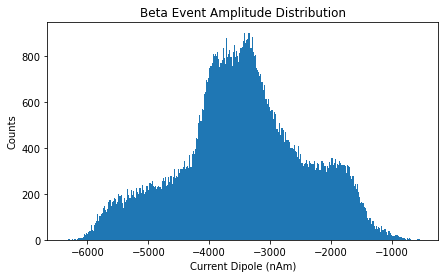

In [8]:
# Beta Event Histogram
plt.figure(figsize=(7,4))
plt.hist(df['amplitude'], bins=int(np.sqrt(df.shape[0])))
plt.xlabel('Current Dipole (nAm)')
plt.ylabel('Counts')
plt.title('Beta Event Amplitude Distribution')
plt.savefig('../figures/beta_event_amplitude_histogram.png')

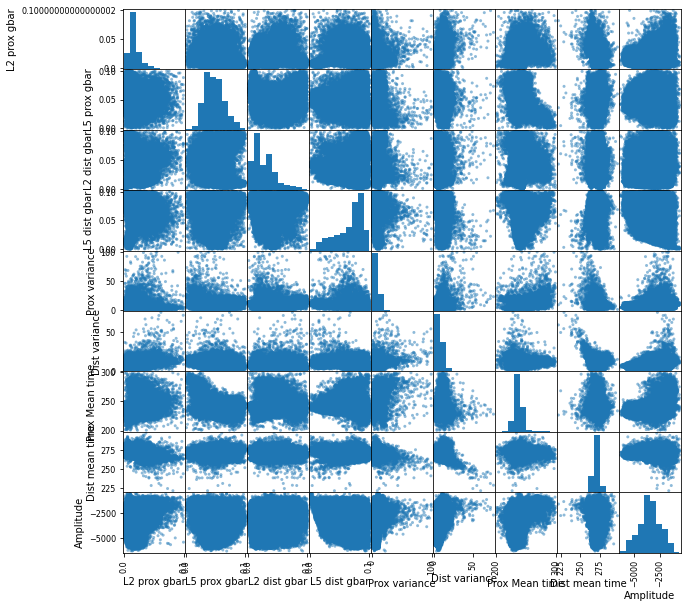

In [21]:
sm = pd.plotting.scatter_matrix(df, figsize=(10,10))


In [ ]:
plt.figure(8,6)
plt.scatter()